<a href="https://colab.research.google.com/github/SRI-CSL/CoProver/blob/main/src/notebooks/220629_metitarski/coprover_metitarski_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoProver: The Cueology of Proof

## &#10024; `MetiTarski`- Variable Ordering Problem

**Description:** Evaluate the transformer architectures, in particular the $T5$ models, for the variable ordering task. The datasets are created using the **preprocess_data.py** Python script located [HERE](https://github.com/SRI-CSL/CoProver/blob/main/src/notebooks/220629_metitarski/preprocess_data.py).

**Copyright 2022 SRI International.**

## &#9776; Import libraries

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score

In [2]:
try:
    from google.colab import data_table, output
    data_table.disable_dataframe_formatter()
    output.enable_custom_widget_manager()
except Exception:
    print("Launched notebook locally")

In [3]:
# install gdown library for .csv files download
try:
    import gdown
except ImportError:
    !pip install gdown

In [4]:
try:
    from simplet5 import SimpleT5
except ImportError:
    !pip install --upgrade simplet5

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


## &#9997; Set configuration

In [5]:
warnings.filterwarnings('ignore')

In [6]:
# origins of the .csv data files used
# True: originating within the signal-public GitHub repository
# False: need to be downloaded from a provided URL, especially useful if running on Colab
IS_LOCAL_FILE = False

In [7]:
# dictionary of files for this notebook to work
# the dictionary is composed of (filename, Google ID) key-value pairs

DATASET_DICT = {
    'metitarski_dataset_v1.csv': '1jOqdNyfTr_8rPtYCZ-4gNifOJWOCtjPj',
    'metitarski_dataset_v2.csv': '1RXJI-1ZKnKs6RhmPlGmM111XHzcfyCDy',
    'metitarski_dataset_transformers_v1.csv': '1G2N3OUnFgv936SXRbdUJ1nQz7nRGAYsF'
    }

## &#9881; Define functions

In [8]:
def path_exists(input_path: str) -> bool:
    return os.path.exists(input_path)

In [9]:
def check_file_status(input_path: str):
    if path_exists(input_path=input_path):
        print(f"- File {input_path.split('/')[-1]} exists locally at {input_path}!")
    else:
        if IS_LOCAL_FILE:
            print("- Something went wrong with the download. Please try again!")
        else:
            print(f"- IS_LOCAL_FILE is set to {IS_LOCAL_FILE}. The file is accessed via a public GitHub link!")

In [10]:
def download_dataset_from_google_drive(google_file_id: str, output_file_name: str, quiet_download: bool) -> str:
    file_path = f'./{output_file_name}'

    if not os.path.exists(file_path):
        gdown.download(id=google_file_id, output=output_file_name, quiet=quiet_download)
    else:
        print(f"{output_file_name} already exists!")
        
    return file_path

In [11]:
def get_dataset(dataset_name: str, is_local_file: bool) -> str:
    file_path = f'./{dataset_name}'

    if is_local_file:
        file_path = f'https://raw.githubusercontent.com/SRI-CSL/CoProver/main/data/{dataset_name}'
    else:
        if dataset_name in DATASET_DICT:
            file_path = download_dataset_from_google_drive(google_file_id=DATASET_DICT[dataset_name], output_file_name=dataset_name, quiet_download=False)
        else:
            print(f"{dataset_name} is not present in dataset dictionary! Please ensure the file name is correct!")
            return

    return file_path

In [47]:
def score_df(input_model, input_df):
  """a slight modification to EY-method ensuring that we retrieve all 
  the necessary output for the confusion matrix construction as np.array

  Note: Trained input_model should be loaded before executing this method
  """

  num_correct = 0
  total = 0
  pred_labels = []
  true_labels = []

  for idx, row in tqdm(input_df.iterrows(), total=len(input_df)):
    # predicted label
    p_label = input_model.predict(row.source_text)[0]

    # true label
    t_label = row.target_text

    pred_labels.append(p_label)
    true_labels.append(t_label)

    total += 1

    if p_label == t_label:
      num_correct += 1

  return num_correct, total, pred_labels, true_labels

## &#9749; Download datasets

In [13]:
# metitarski_dataset_transformers_v1.csv
path_metitarski = get_dataset(dataset_name='metitarski_dataset_transformers_v1.csv', is_local_file=IS_LOCAL_FILE)

Downloading...
From: https://drive.google.com/uc?id=1G2N3OUnFgv936SXRbdUJ1nQz7nRGAYsF
To: /content/metitarski_dataset_transformers_v1.csv
100%|██████████| 1.11M/1.11M [00:00<00:00, 121MB/s]


In [14]:
check_file_status(input_path=path_metitarski)

- File metitarski_dataset_transformers_v1.csv exists locally at ./metitarski_dataset_transformers_v1.csv!


## &#128722; Load data

In [29]:
df_metitarski = pd.read_csv(path_metitarski, sep='\t')

In [30]:
df_metitarski.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6895 entries, 0 to 6894
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   6895 non-null   int64 
 1   source_text  6895 non-null   object
 2   target_text  6895 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 161.7+ KB


In [31]:
df_metitarski = df_metitarski.drop('Unnamed: 0', axis=1)

In [32]:
df_metitarski['target_text'] = df_metitarski['target_text'].apply(str)

In [33]:
df_metitarski.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6895 entries, 0 to 6894
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  6895 non-null   object
 1   target_text  6895 non-null   object
dtypes: object(2)
memory usage: 107.9+ KB


In [34]:
df_metitarski.head()

,source_text,target_text
0,x1 _ x2 x1 x3 x2,0
1,$ _ x2 $*x1^2*x2 _ $*x2^3 _ $*x2^5 _ $*x2^7 _ ...,4
2,$ _ x3 $ _ x3 $ _ x2 $ _ x1 x3 _ $ x2 _ $ x1 _...,5
3,(x1^4*x1^4 _ $*x1^2 _ $) x2 x1 $ _ $*x3 $*x3 _...,2
4,$*x1^2*x2^4 _ $*x1^4*x2^2 _ $*x1^2*x2^6 _ $*x1...,5


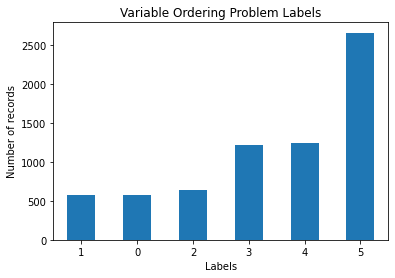

In [35]:
tmp_target = df_metitarski.groupby(df_metitarski.target_text).size().sort_values()
tmp_target.plot.bar(title="Variable Ordering Problem Labels", xlabel="Labels", ylabel="Number of records", rot=0, log=False)

In [36]:
# prefixes are always expected
SEQ_PREFIX = "sequence: "

In [37]:
df_metitarski['source_text'] = SEQ_PREFIX + df_metitarski['source_text']

In [38]:
train_df, test_df = train_test_split(df_metitarski, 
                                     test_size=0.2, 
                                     random_state=1337, 
                                     shuffle=True)

In [39]:
train_df.shape, test_df.shape

((5516, 2), (1379, 2))

## &#129504; Transformers

### &#128722; T5 Model Load

In [40]:
model = SimpleT5()

In [41]:
model.from_pretrained(model_type="t5", model_name="t5-base")

### &#128640; Hyperparameter setup

In [42]:
SOURCE_MAX_TOKEN_LEN = max([len(x.split()) for x in df_metitarski['source_text']]) + 10
TARGET_MAX_TOKEN_LEN = 5
BATCH_SIZE = 4
MAX_EPOCH = 3
DATALOADER_NUM_WORKERS = 4
SAVE_ONLY_LAST_EPOCH = True
USE_GPU = True
NUM_GPUS = 1

### &#9203; Training

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5516 entries, 6363 to 3223
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  5516 non-null   object
 1   target_text  5516 non-null   object
dtypes: object(2)
memory usage: 129.3+ KB


In [44]:
model.train(train_df=train_df,
            eval_df=test_df, 
            source_max_token_len=SOURCE_MAX_TOKEN_LEN, 
            target_max_token_len=TARGET_MAX_TOKEN_LEN, 
            batch_size=BATCH_SIZE, 
            max_epochs=MAX_EPOCH, 
            use_gpu=USE_GPU)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### &#129514; Testing

In [45]:
# Load the trained model
trained_model_path = './outputs/simplet5-epoch-2-train-loss-0.5633-val-loss-0.5276'
model.load_model("t5", trained_model_path, use_gpu=False)

In [48]:
# return num_correct, total, pred_labels, true_labels
correct_preds, total_samples, pred_labels_lst, true_labels_lst = score_df(input_model=model, input_df=test_df)


100%|██████████| 1379/1379 [18:53<00:00,  1.22it/s]


In [49]:
print(f"{correct_preds} polynomial sequences were predicted CORRECTLY out of {total_samples} samples present in the input DataFrame.\tAccuracy: {correct_preds/total_samples:.3f}")

727 polynomial sequences were predicted CORRECTLY out of 1379 samples present in the input DataFrame.	Accuracy: 0.527
